In [1]:
# First import library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2
# Import argparse for command-line options
import argparse
# Import os.path for file path manipulation
import os.path
import matplotlib.pyplot as plt
import progressbar
import time
import json

OV9282 sensor

image area : 3896 x 2453 µm

pixel size : 3.0 µm

# 1. depth example
### 1.0 configuration of the camera
1. load pre-defined configuration
2. start pipeline and get depth scale factor

In [2]:
DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")
    
try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")
    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")
    # Get each control's current value
    
    # Serialize all controls to a Json string
    serialized_string = advnc_mode.serialize_json()
    #print("Controls as JSON: \n", serialized_string)
    as_json_object = json.load(open('high_acc.json'))
    # We can also load controls from a json string
    # The C++ JSON parser requires double-quotes for the json object so we need
    #  to replace the single quote of the pythonic json to double-quotes
    json_string = str(as_json_object).replace("'", '\"')
    advnc_mode.load_json(json_string)
except Exception as e:
    print(e)
    pass

Found device that supports advanced mode: Intel RealSense 435
Advanced mode is enabled


In [3]:
pipeline = rs.pipeline()

#Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 360, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

Depth Scale is:  0.0010000000474974513


max distance is : 4434 min is : 0


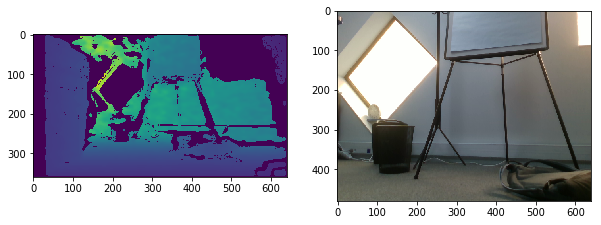

In [4]:
i = 0
while True:
    # This call waits until a new coherent set of frames is available on a device
    # Calls to get_frame_data(...) and get_frame_timestamp(...) on a device will return stable values until wait_for_frames(...) is called
    frames = pipeline.wait_for_frames()
    depth = frames.get_depth_frame()
    color = frames.get_color_frame()
    if not depth: continue
    dd = np.asanyarray(depth.get_data())
    rr = np.asanyarray(color.get_data())
    print('max distance is :',dd.max(),'min is :', dd.min())
    #np.save('frames/rgb/'+str(i).zfill(3)+'.npy', rr)
    #np.save('frames/d/'+str(i).zfill(3)+'.npy', dd)
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(dd)
    plt.subplot(122);plt.imshow(rr)
    i = i + 1
    break

### 1.1 by get_distance()
To test on "how to get the destance prediction from the output we received"

In [58]:
def get_depth(depth, bbx):
    #input depth is a frames.get_depth_frame()
    #bbx is x_min, y_min, x_max, y_max
    hh = bbx[2]-bbx[0]
    ww = bbx[3]-bbx[1]
    result = np.zeros((hh,ww))
    for i in range(hh):
        for j in range(ww):
            x = int(i+bbx[0])
            y = int(j+bbx[1])
            result[i,j] = depth.get_distance(y,x)
    return result

max distance is : 65.53500366210938 min is : 0.0


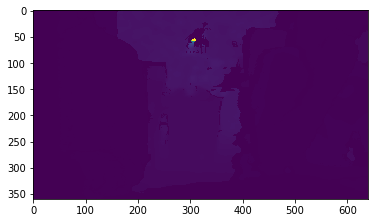

In [62]:
dd_part = get_depth(depth, [0,0,360,640])
plt.imshow(dd_part)
print('max distance is :',dd_part.max(),'; min is :', dd_part.min())

the difference between depth(color)*depth_scale and depth.get_distance()

In [65]:
error = 0
for x in range(360):
    for y in range(640):
        error += dd[x,y]*depth_scale - depth.get_distance(y,x)
print(error)

6.221968214958906e-05


As a result, the depth * depth_scale is the distance calculated by the realsense camera.

# 2. Point cloud

In [96]:
pc = rs.pointcloud()
depth = frames.get_depth_frame()
color = frames.get_color_frame()
pc.map_to(color)
points = pc.calculate(depth)
points.export_to_ply("1.ply", color)

In [29]:
pts = np.asanyarray(points.get_data())

# 3. Read bag of the output

In [18]:
inp = '20180716_140440.bag'
# Create pipeline
pipeline = rs.pipeline()
# Create a config object
config = rs.config()
# Tell config that we will use a recorded device from filem to be used by the pipeline through playback.
rs.config.enable_device_from_file(config, inp)
# Configure the pipeline to stream the depth stream
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
#config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
# Start streaming from file
pipeline.start(config)

# Create opencv window to render image in
cv2.namedWindow("Depth Stream", cv2.WINDOW_AUTOSIZE)

# Streaming loop
i = 0
while True:
    # Get frameset of depth
    frames = pipeline.wait_for_frames()
    # Get depth frame
    depth_frame = frames.get_depth_frame()
    image_frame = frames.get_color_frame()
    # Colorize depth frame to jet colormap
    depth_color_frame = rs.colorizer().colorize(depth_frame)
    # Convert depth_frame to numpy array to render image in opencv
    depth_color_image = np.asanyarray(depth_color_frame.get_data())
    #color_image = np.asanyarray(image_frame.get_data())
    # Render image in opencv window
    cv2.imshow("Depth Stream", depth_color_image)
    #cv2.imshow("Depth Stream", color_image)
    key = cv2.waitKey(1)
    # if pressed escape exit program
    if i >= 27:
        cv2.destroyAllWindows()
        break
    i += 1

# 4.  intrinsics matrix

#### depth camera information 

In [24]:
videoprofile = pipeline.get_active_profile().get_stream(rs.stream.depth)

In [25]:
rs.video_stream_profile(videoprofile).get_intrinsics()

width: 640, height: 360, ppx: 321.75, ppy: 178.045, fx: 321.027, fy: 321.027, model: Brown Conrady

#### color camera information

In [26]:
videoprofile = pipeline.get_active_profile().get_stream(rs.stream.color)
rs.video_stream_profile(videoprofile).get_intrinsics()

width: 640, height: 480, ppx: 327.327, ppy: 239.649, fx: 620.423, fy: 620.95, model: Brown Conrady

# 5.  extrinsics matrix
To get the values of the extrinsics matrix

In [ ]:
pipe = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 360, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
selection = pipe.start(config)

depth_stream = selection.get_stream(rs.stream.depth)
color_stream = selection.get_stream(rs.stream.color)
extrinsics= depth_stream.get_extrinsics_to(color_stream)

In [39]:
extrinsics

( (0.999994, 0.000629995, -0.00339905, -0.000623888, 0.999998, 0.0017974, 0.00340017, -0.00179527, 0.999993), (0.0146588, 3.2228e-05, 0.000547202) )

# 6. Align and save images

In [5]:
numm = 400
i = 0
bar = progressbar.ProgressBar(maxval=numm, \
            widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
while True:
    # This call waits until a new coherent set of frames is available on a device
    # Calls to get_frame_data(...) and get_frame_timestamp(...) on a device will return stable values until wait_for_frames(...) is called
    frames = pipeline.wait_for_frames()
    align_to = rs.stream.color
    align = rs.align(align_to)
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    #plt.figure(figsize = (10,10))
    #plt.subplot(121);plt.imshow(depth_image)
    #plt.subplot(122);plt.imshow(color_image)
    np.save('frames/rgb/'+str(i).zfill(3)+'.npy', color_image)
    np.save('frames/d/'+str(i).zfill(3)+'.npy', depth_image)
    if i > numm-1:
        break
    bar.update(i+1)
    i = i + 1
    time.sleep(0.1)
bar.finish()

KeyboardInterrupt: 